pip install cmdstanpy
cmdstanpy.install_cmdstan(COMPILER=True)  # Uncomment this line if CmdStan is not installed


import cmdstanpy

cmdstanpy.install_cmdstan()  # Uncomment this line if CmdStan is not installed

In [1]:

import cmdstanpy

cmdstanpy.install_cmdstan(compiler=True)  # Uncomment this line if CmdStan is not installed

CmdStan install directory: /Users/yndk/.cmdstan
CmdStan version 2.37.0 already installed
Test model compilation


True

In [2]:
stan_code = """
data {
  // N is the total number of trials (80 + 20 = 100)
  int<lower=0> N; 
  // y is the number of "successes" (80)
  int<lower=0, upper=N> y; 
}

parameters {
  // theta is the parameter we want to sample, constrained between 0 and 1
  real<lower=0, upper=1> theta;
}

transformed parameters {
  // Define the probability of success 'p' based on the relationship 
  // from the likelihood function: p = (1 + theta) / 2
  real<lower=0, upper=1> p = (1.0 + theta) / 2.0;
}

model {
  // 1. PRIOR (Prior(theta) = theta^3 * (1-theta))
  // This is proportional to a Beta(4, 2) distribution 
  // (since Beta(a, b) is proportional to theta^(a-1) * (1-theta)^(b-1))
  target += beta_lpdf(theta | 4, 2);
  
  // 2. LIKELIHOOD (L(theta) = ((1+theta)/2)^80 * ((1-theta)/2)^20)
  // This is the log probability mass function (lpmf) of a Binomial distribution
  // with 'y' successes out of 'N' trials and success probability 'p'.
  target += binomial_lpmf(y | N, p);
  
  // Stan automatically combines the log-prior and log-likelihood to sample 
  // from the unnormalized log-posterior distribution.
}
"""

stan_file = 'bayes_model.stan'
with open(stan_file, 'w') as f:
    f.write(stan_code)


In [3]:
# Stan code using '~' notation for prior and likelihood
stan_code_simple = """
data {
  int<lower=0> N;
  int<lower=0, upper=N> y;
}
parameters {
  real<lower=0, upper=1> theta;
}
transformed parameters {
  real<lower=0, upper=1> p = (1.0 + theta) / 2.0;
}

// Note: 'y' is the observed data, so we may use '~' notation even if the probability model is a discrete PMF.
model {
  theta ~ beta(4, 2);
  y ~ binomial(N, p); 
}
"""
stan_file_simple = 'bayes_model_simple.stan'
with open(stan_file_simple, 'w') as f:
    f.write(stan_code_simple)


In [4]:
import cmdstanpy
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Define Data and Model ---

# Data corresponding to the likelihood function:
# L(theta) = ((1+theta)/2)^80 * ((1-theta)/2)^20
stan_data = {
    'N': 100,  # Total trials: 80 + 20
    'y': 80    # Successes
}

# stan_file = 'bayesian_model.stan'
model_name = os.path.splitext(stan_file)[0]
print(f"Model name: {model_name}")


Model name: bayes_model


In [5]:
# --- 2. Compile and Instantiate Model ---
try:
    print(f"Compiling Stan model: {stan_file}...")
    model = cmdstanpy.CmdStanModel(stan_file=stan_file)
    print("Model compiled successfully.")
except Exception as e:
    print(f"Error compiling Stan model: {e}")
    print("Please ensure CmdStan is installed and configured correctly.")
    exit()


12:55:05 - cmdstanpy - INFO - compiling stan file /Users/yndk/Desktop/KOS6002/bayes_model.stan to exe file /Users/yndk/Desktop/KOS6002/bayes_model


Compiling Stan model: bayes_model.stan...


12:55:07 - cmdstanpy - INFO - compiled model executable: /Users/yndk/Desktop/KOS6002/bayes_model


Model compiled successfully.


In [6]:
model

CmdStanModel: name=bayes_model
	 stan_file=/Users/yndk/Desktop/KOS6002/bayes_model.stan
	 exe_file=/Users/yndk/Desktop/KOS6002/bayes_model
	 compiler_options=stanc_options={}, cpp_options={}

In [7]:
# --- 3. Run MCMC Sampling (HMC) ---
try:
    print("Starting HMC sampling...")
    fit = model.sample(
        data=stan_data,
        chains=4,          # Run 4 independent Markov chains
        iter_warmup=1000,  # Burn-in period
        iter_sampling=2000, # Number of samples to draw after warmup
        seed=1234          # For reproducibility
    )
    print("Sampling completed.")
except Exception as e:
    print(f"Error during sampling: {e}")
    exit()



Starting HMC sampling...


12:55:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:55:08 - cmdstanpy - INFO - CmdStan done processing.



Sampling completed.


In [8]:
summary = fit.summary()
summary

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,-3.690680,0.012360,0.731066,0.311198,-5.168500,-3.410280,-3.184380,3822.11,4555.12,69493.0,1.00017
theta,0.604976,0.001436,0.073623,0.073126,0.479290,0.608472,0.719843,2627.84,3902.96,47778.8,1.00080
p,0.802488,0.000718,0.036812,0.036563,0.739645,0.804236,0.859922,2627.84,3902.96,47778.8,1.00080


In [9]:
df = fit.draws_pd()
theta_samples = df['theta'].values

Theta summary statistics:
Mean              0.604976
MCSE              0.001436
StdDev            0.073623
MAD               0.073126
5%                0.479290
50%               0.608472
95%               0.719843
ESS_bulk       2627.840000
ESS_tail       3902.960000
ESS_bulk/s    47778.800000
R_hat             1.000800
Name: theta, dtype: float64


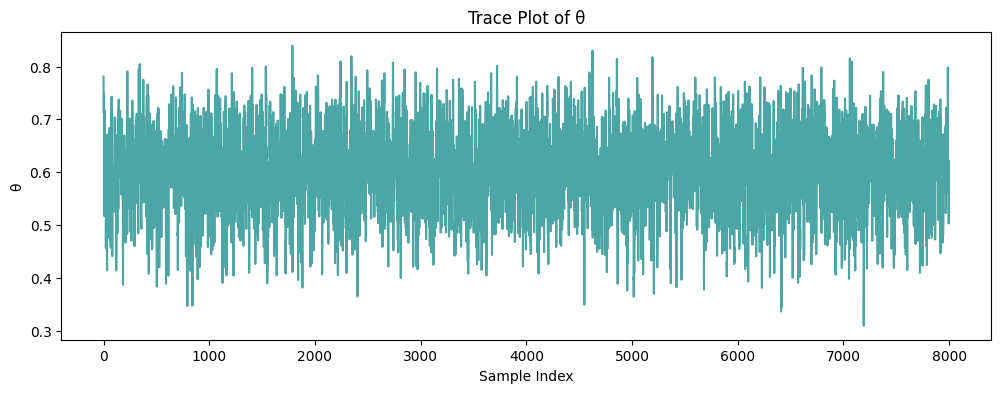

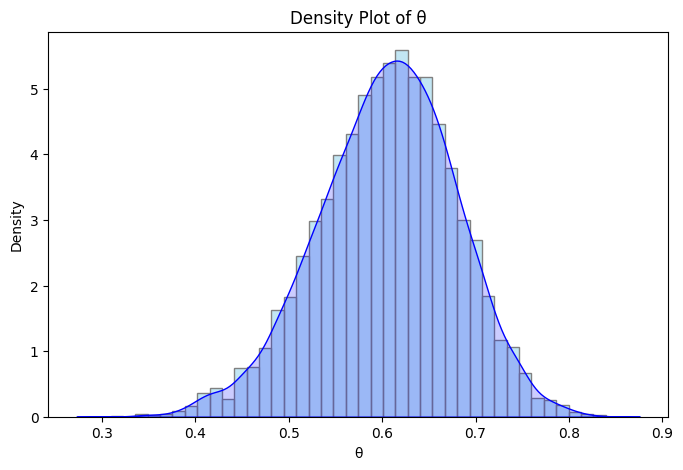

In [10]:
import seaborn as sns


# --- 4. Analyze and Plot Results ---

# Extract samples of theta (parameters are stored in an xarray dataset)
theta_samples = fit.stan_variable('theta')

# Flatten all chains into a single array for plotting
all_samples = theta_samples.flatten()
theta_summary = summary.loc['theta']
print("Theta summary statistics:")
print(theta_summary)

# Trace plot of theta
plt.figure(figsize=(12, 4))
plt.plot(all_samples, color='teal', alpha=0.7)
plt.title('Trace Plot of θ')
plt.xlabel('Sample Index')
plt.ylabel('θ')
plt.show()

# Density plot of theta (KDE only)
plt.figure(figsize=(8, 5))
sns.histplot(all_samples, bins=40, color='skyblue', stat='density', alpha=0.5, edgecolor='gray')
sns.kdeplot(all_samples, color='blue', fill=True, alpha=0.2)
plt.title('Density Plot of θ')
plt.xlabel('θ')
plt.ylabel('Density')
plt.show()

12:55:08 - cmdstanpy - INFO - compiling stan file /Users/yndk/Desktop/KOS6002/bayes_model_simple.stan to exe file /Users/yndk/Desktop/KOS6002/bayes_model_simple
12:55:10 - cmdstanpy - INFO - compiled model executable: /Users/yndk/Desktop/KOS6002/bayes_model_simple
12:55:10 - cmdstanpy - INFO - compiled model executable: /Users/yndk/Desktop/KOS6002/bayes_model_simple
12:55:11 - cmdstanpy - INFO - CmdStan start processing
12:55:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:55:11 - cmdstanpy - INFO - CmdStan done processing.


12:55:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:55:11 - cmdstanpy - INFO - CmdStan done processing.



Original Stan code summary:
           Mean      MCSE    StdDev       MAD        5%       50%       95%  \
lp__  -3.690680  0.012360  0.731066  0.311198 -5.168500 -3.410280 -3.184380   
theta  0.604976  0.001436  0.073623  0.073126  0.479290  0.608472  0.719843   
p      0.802488  0.000718  0.036812  0.036563  0.739645  0.804236  0.859922   

       ESS_bulk  ESS_tail  ESS_bulk/s    R_hat  
lp__    3822.11   4555.12    115822.0  1.00017  
theta   2627.84   3902.96     79631.4  1.00080  
p       2627.84   3902.96     79631.4  1.00080  
Simple Stan code summary:
            Mean      MCSE    StdDev       MAD         5%        50%  \
lp__  -54.419700  0.012524  0.730721  0.310282 -55.896700 -54.136100   
theta   0.602675  0.001362  0.074091  0.073434   0.474868   0.606214   
p       0.801337  0.000681  0.037045  0.036717   0.737434   0.803107   

             95%  ESS_bulk  ESS_tail  ESS_bulk/s    R_hat  
lp__  -53.910200   3912.34   4557.91     43958.9  1.00020  
theta   0.718528   2983

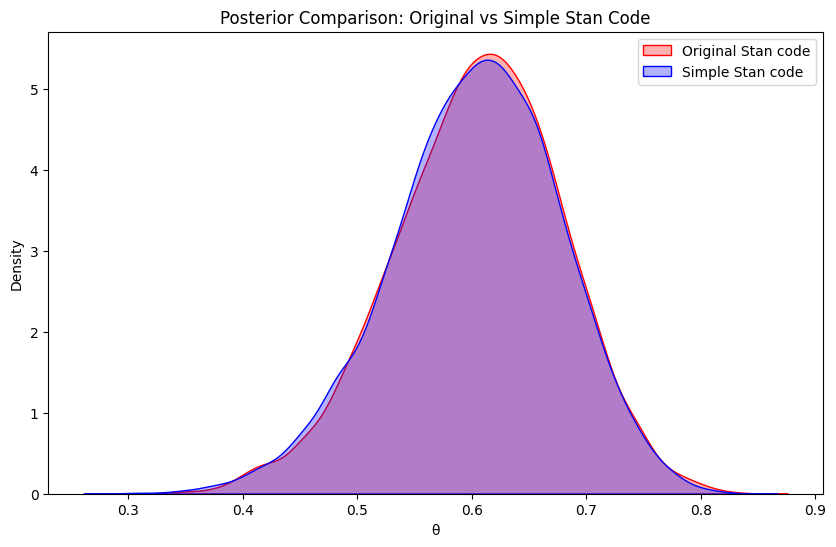

In [11]:
# --- Comparison of Stan Models ---
import pandas as pd

# Compile both models
model_original = cmdstanpy.CmdStanModel(stan_file='bayes_model.stan')
model_simple = cmdstanpy.CmdStanModel(stan_file='bayes_model_simple.stan')

# Sample from both models
fit_original = model_original.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=2000, seed=1234)
fit_simple = model_simple.sample(data=stan_data, chains=4, iter_warmup=1000, iter_sampling=2000, seed=1234)

# Extract theta samples
theta_orig = fit_original.stan_variable('theta').flatten()
theta_simp = fit_simple.stan_variable('theta').flatten()

# Print summary statistics
print('Original Stan code summary:')
print(fit_original.summary())
print('Simple Stan code summary:')
print(fit_simple.summary())

# Plot comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(theta_orig, color='red', label='Original Stan code', fill=True, alpha=0.3)
sns.kdeplot(theta_simp, color='blue', label='Simple Stan code', fill=True, alpha=0.3)
plt.title('Posterior Comparison: Original vs Simple Stan Code')
plt.xlabel('θ')
plt.ylabel('Density')
plt.legend()
plt.show()